<a href="https://colab.research.google.com/github/tayfununal/hamiltonian_ex/blob/main/stormer_verlet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#verlet
import math
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

plt.style.use('seaborn-poster')

def verlet(h = 0.5, initial_point=[0., 1.]):
  t = np.arange(0, 2*np.pi, h)

  qv = np.zeros(t.shape[0])
  pv = np.zeros(t.shape[0])

  qv[0] = initial_point[0]
  pv[0] = initial_point[1]
  
  for i in range(0 ,t.shape[0]-1):
    ara_p = pv[i] - h/2 * qv[i]

    qv[i+1] = qv[i] + h * (pv[i] - h/2 * qv[i])

    pv[i+1] = ara_p - h/2 * (qv[i] + h * (pv[i] - h/2 * qv[i]))

  return qv, pv, t

q, p, t = verlet()


def grand_truth_plot(h = 0.1):
  t = np.arange(0,2*np.pi,0.3)
  q = np.sin(t)
  p = np.cos(t)
  plt.scatter(q,p)

def pred_plot(q, p):
  plt.plot(q[:, ], p[:,], c = "red")
  plt.xlabel('q')
  plt.ylabel('p')

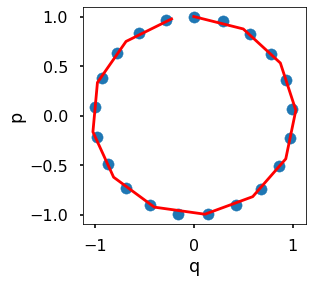

In [2]:
plt.figure(figsize = (4, 4))

pred_plot(q=q, p=p)

grand_truth_plot()
plt.show()

In [3]:
target = np.concatenate((q.reshape(-1,1), p.reshape(-1,1)) , axis=1)

In [4]:
inp = Input(shape=(1,))

x = Dense(64, activation="tanh")(inp)
x = Dense(64, activation="tanh")(x)

out = Dense(2)(x)

model = Model(inputs=inp, outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 4,418
Trainable params: 4,418
Non-trainable params: 0
_________________________________________________________________


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt , loss="mse")
model.fit(x=t, y=target , epochs=200, batch_size=16)

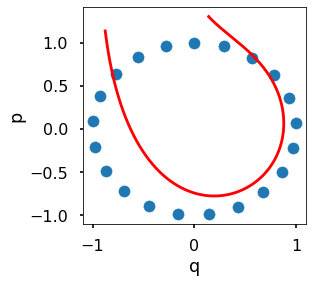

In [6]:
# prediction q and p Using NN and with test_t 
test_t = np.arange(0, 2*np.pi, 0.001)
prediction = model(test_t).numpy()

q = prediction[:,0]
p = prediction[:,1]

plt.figure(figsize = (4, 4))

# NN with mse solition 
pred_plot(q, p )

# Grand truth solution plot
grand_truth_plot()

plt.show()

In [7]:
# NN model with Hamiltonian preserved loss
inp = Input(shape=(2,))

x = Dense(64, activation="tanh")(inp)
x = Dense(64, activation="tanh")(x)

out = Dense(2)(x)

model2 = Model(inputs=inp, outputs=out)

In [8]:
def H(z):
  return tf.reduce_sum((z**2)/2,axis=1)

def custom_loss(y_true, y_pred):
  return (1/32) *(y_true - H(y_pred))**2

In [9]:
# Hamiltonian preserved for initial point and we extend this for all test_t
h_0 = np.array([0.5 for i in range(test_t.shape[0])])

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model2.compile(optimizer=opt, loss=custom_loss)
model2.fit(x = prediction, y = h_0, epochs=100, batch_size=32)

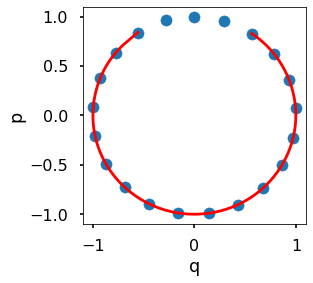

In [11]:
test_t = np.arange(0, 2*np.pi, 0.0001)

prediction_with_hamiltonian_preserved = model2(model(test_t))

q = prediction_with_hamiltonian_preserved[:,0]
p = prediction_with_hamiltonian_preserved[:,1]

plt.figure(figsize = (4, 4))
pred_plot(q=q, p=p)

grand_truth_plot()
plt.show()

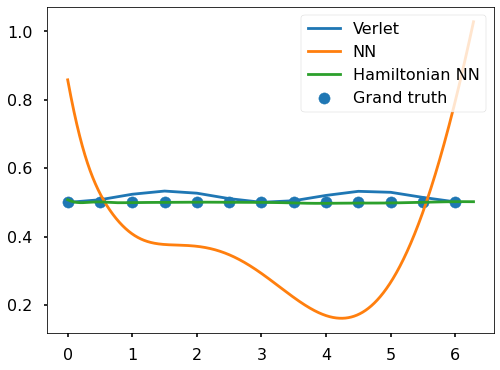

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(t, [0.5 for i in range(t.shape[0])], label="Grand truth")
plt.plot(t ,H(target), label= "Verlet")
plt.plot(np.arange(0, 2*np.pi, 0.001), H(prediction), label= "NN")
plt.plot(test_t, H(prediction_with_hamiltonian_preserved), label="Hamiltonian NN")
plt.legend(loc="upper right")
plt.show()